In [13]:
# keras imports for the dataset and building our neural network
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils


### References: https://towardsdatascience.com/how-to-create-custom-real-time-plots-in-deep-learning-ecbdb3e7922f
### References: https://www.analyticsvidhya.com/blog/2020/11/tutorial-how-to-visualize-feature-maps-directly-from-cnn-layers/

class TrainingVis(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.f1score = []
        self.precision = []
        self.recall = []
        self.categorical_accuracy = []
        self.logs = []

    def on_train_batch_end(self,batch,logs={}):
        
        
        if batch%1 ==0:
            layer_names = [layer.name for layer in model.layers]
            layer_outputs = [layer.output for layer in model.layers]
            feature_map_model = Model(inputs=model.input, outputs=layer_outputs)

            # create a feature map of dimension [1 : im.height : im.width : num_filters ]
            #feature_maps = feature_map_model.predict(X_sample)
            feature_maps = feature_map_model.predict(X_random_test)

            clear_output(wait=True)

            for layer_name, feature_map in zip(layer_names, feature_maps):  


                if len(feature_map.shape) == 4:
                    k = feature_map.shape[-1]  
                    size=feature_map.shape[1]
                    image_belt = np.zeros((size,size*k))


                    for i in range(k):

                        # for every filter, visualize the activation    
                        feature_image = feature_map[0, :, :, i]
                        feature_image-= feature_image.mean()
                        feature_image/= feature_image.std ()
                        feature_image*=  25
                        feature_image+= 50

                        # Threshold the feature map to become a binary image 
                        feature_image = feature_image < 80
                        image_belt[:, i * size : (i + 1) * size] = feature_image 

                    scale = 20. / k
                    plt.figure( figsize=(scale * k, scale) )
                    plt.title ( layer_name )
                    plt.grid  ( False )
                    plt.imshow( image_belt, aspect='auto')
                    plt.show()


# to calculate accuracy
from sklearn.metrics import accuracy_score

# loading the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()


# building the input vector from the 28x28 pixels
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

X_sample = X_train[22,:,:,:].reshape(1,28,28,1)

X_random = np.zeros((28,28))
for i in range(X_random.shape[0]):
    for j in range(X_random.shape[1]):
        X_random[i,j] = np.random.randint(0,255)

X_random_test = X_random.reshape(1,28,28,1)

print(X_random_test.shape)



print(X_sample.shape)

# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

# building a linear stack of layers with the sequential model
model = Sequential()
# convolutional layer
model.add(Conv2D(10, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(1,1)))
# flatten output of conv
model.add(Flatten())
# hidden layer
model.add(Dense(50, activation='relu'))
# output layer
model.add(Dense(10, activation='softmax'))

metrics = [
    
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy")
]
plot_metrics = TrainingVis()

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics = metrics,optimizer='adam')







(1, 28, 28, 1)
(1, 28, 28, 1)
Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


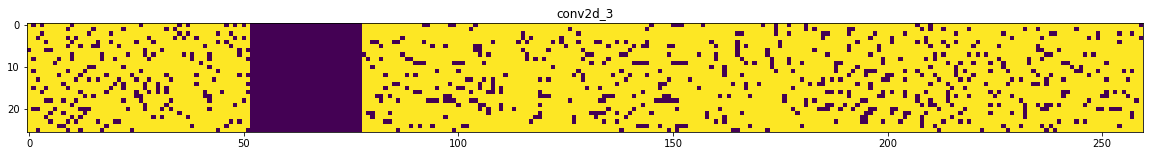

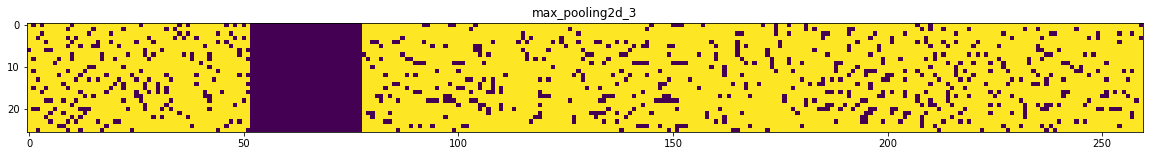

235/235 [==============================] - 70s 297ms/step - loss: 0.7139 - tp: 23087.6737 - tn: 271618.9449 - fn: 7245.8856 - fp: 1383.0890 - categorical_accuracy: 0.8182 - val_loss: 0.1390 - val_tp: 9531.0000 - val_tn: 89706.0000 - val_fn: 469.0000 - val_fp: 294.0000 - val_categorical_accuracy: 0.9610


In [14]:
# training the model example by example, to wath the feature map change as weights are learned.
model.fit(X_train, Y_train, batch_size=256, epochs=1, callbacks =[plot_metrics], validation_data=(X_test, Y_test))

